### please send the solution to carlop@ethz.ch from your institutional e-mail address

## Determine the critical temperature $T_c$ for a square lattice of spins with nearest neighbor interactions obeying the the Ising model Hamiltonian:
$\begin{equation}
    H=-J\sum_{<i,j>} \sigma_i \sigma_j
\end{equation}$
Where $J=0.01 eV$ and $\sigma_i$ can assume values $+1$ or $-1$

Consider a square lattice with $L \times L$ spins ($L=32$) and periodic boundary conditions. 

Run a Metropolis Monte Carlo simulation, where at each step you flip one spin selected randomly, to compute and plot:
1) $<|M|>$ 
where $M$ is the magnetization: $M=\frac{1}{L^2}\sum_{i}\sigma_i$     
2) the constant volume specific heat 
$<C_v>=\frac{\partial <E>}{\partial T}=\frac{\beta^2}{N(<E^2>-<E>^2)}$ (Fluctuation dissipation theorem)

Consider a grid of $~10$ different temperatures between $230K$ and $300K$. For each temperature, starting from a random configuration of spins in the lattice, compute $10$ values of $<|M|>$ and of $<C_v>$ over $800000$ MC moves. Plot for each temperature the average of the $10$ measurements (see example in Figure ). For each temperature, discard the initial $800000$ moves to allow for thermalization of the system. Record the percentage of accepted moves for each temperature and comment on the result.
The number of MC moves suggested for the exercise is lower compared to the one adopted in Figure . The results that you will obtain will be less accurate.

In [1]:
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [2]:
L=32
J=-0.01
termsteps=1
steps=11
sampsize=800000
kb = constants.physical_constants['Boltzmann constant in eV/K'][0]

In [3]:
Tc=-2*J/(np.log(1+np.sqrt(2)))/kb

In [4]:
Tc

263.3280210038397

In [5]:
#certae a function to compute PBC
def pbc(i,j,lx,ly):
    return ((i) % lx, (j) % ly)

In [6]:
#create two functions to compute the energy of a configuration and the magnetization
def energy(i, j, spins,J,Lx,Ly):
    H = 0
    H += spins[i, j] * spins[pbc(i + 1, j + 0, Lx, Ly)]
    H += spins[i, j] * spins[pbc(i + -1, j + 0, Lx, Ly)]
    H += spins[i, j] * spins[pbc(i + 0, j + 1, Lx, Ly)]
    H += spins[i, j] * spins[pbc(i + 0, j + -1, Lx, Ly)]
    return J * H

def magnetization(spins):
    return np.abs(np.sum(spins)) / L**2

In [7]:
energies = []
energies_sq = []
mag = []
cv = []
magm = []
cvm = []
snapshot = []
for T in np.linspace(230,300,10): #main loop on the different Temperatures
    Na=0
    Nr=0
    t0=time.perf_counter()
    print(T)
    spins=np.where(np.random.sample([L,L]) < 0.5, 1, -1)
    beta = 1/(kb*T)
    prefact=beta*beta/(L*L)
    rates={}
    for DE in [-8,-4,0,4,8]: # what is this trick...? (almost useless in this case)
                             # energy difference will be one of the following, depending on the neighbors of a site
                             # so precompute bc exp is expensive
        rates[DE]=np.exp(-1*J*DE*beta)
    TotEne = 0.0
    for i in range(L): #compute intial value of energy
        for j in range(L):
            TotEne+=energy(i, j, spins, J, L, L)
    TotEne /= 2

    for step in range(steps):
        step_e = []
        #step_esq = []
        step_m = []
        #generate sampsize random numbers for i,j and r. r will be used for the boltzmann factor
        for i,j,r in zip(np.random.randint(0,L,sampsize),np.random.randint(0,L,sampsize),np.random.random(sampsize)):
            spins[i, j] *= -1
            de = energy(i, j, spins, J, L, L) * 2
            DE = np.exp(-beta * de)
            # decide whether to accept or not th emove
            if r < DE:
                Na+=1
                TotEne += de
            else:
                spins[i, j] *= -1
                Nr+=1
            step_e.append(TotEne) #store values of energy to compute average later
            step_m.append(magnetization(spins)) #store values of |M|
        if step > termsteps: #start accumulting statistics after termalization step
            esq = np.array(step_e)*np.array(step_e)
            mag.append((T,np.average(step_m)))
            
            cv.append((T,prefact * np.var(step_e)))
    # store averages among "steps" measurements of  |M| and Cv (red dots)
    # to average on the same value of T the last "steps-termsteps" entries are considered
    magm.append((T,np.average(np.array(mag)[-(steps-termsteps)+1:,1])))
    cvm.append((T,np.average(np.array(cv)[-(steps-termsteps)+1:,1])))
    t1=time.perf_counter()
    snapshot.append(spins)
    print(f"Time: {t1 - t0:0.4f} seconds")
    print(f"acceptance rate {Na/(Na+Nr)*100:0.0f} %")

230.0
Time: 79.7362 seconds
acceptance rate 8 %
237.77777777777777
Time: 82.5077 seconds
acceptance rate 10 %
245.55555555555554
Time: 83.3960 seconds
acceptance rate 12 %
253.33333333333334
Time: 82.2639 seconds
acceptance rate 14 %
261.1111111111111
Time: 82.2168 seconds
acceptance rate 18 %
268.8888888888889
Time: 82.4767 seconds
acceptance rate 23 %
276.6666666666667
Time: 84.9815 seconds
acceptance rate 27 %
284.44444444444446
Time: 82.5171 seconds
acceptance rate 30 %
292.22222222222223
Time: 82.0520 seconds
acceptance rate 33 %
300.0
Time: 81.6652 seconds
acceptance rate 35 %


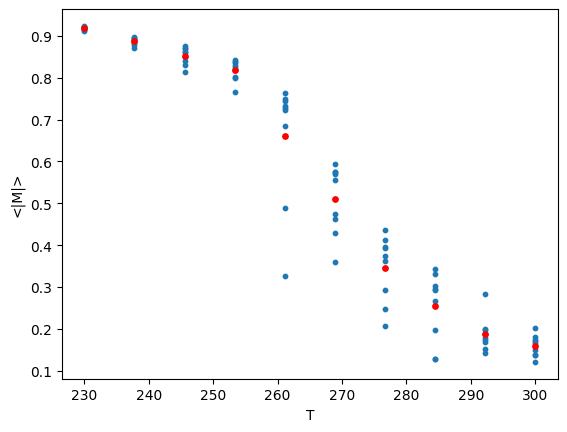

In [8]:
plt.scatter(np.array(mag)[:,0],np.array(mag)[:,1],s=10)
plt.scatter(np.array(magm)[:,0],np.array(magm)[:,1],s=15, c='r')
plt.xlabel("T")
plt.ylabel("<|M|>")
plt.savefig("M.png",dpi=300)

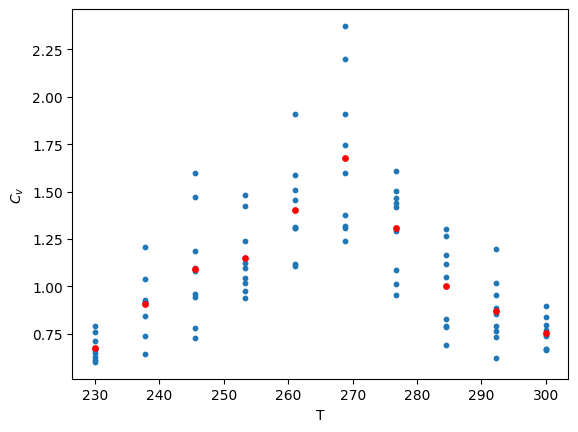

In [9]:
plt.scatter(np.array(cv)[:,0],np.array(cv)[:,1],s=10)
plt.scatter(np.array(cvm)[:,0],np.array(cvm)[:,1],s=15, c='r')
plt.xlabel("T")
plt.ylabel("$C_v$")
plt.savefig("cv.png",dpi=300)

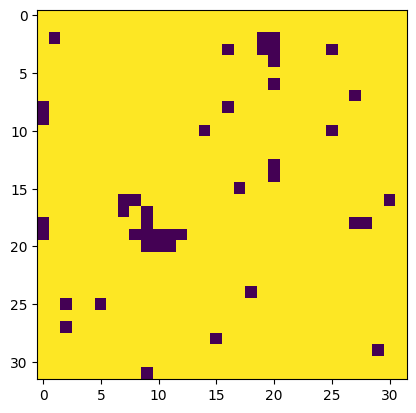

In [10]:
plt.imshow(snapshot[0])

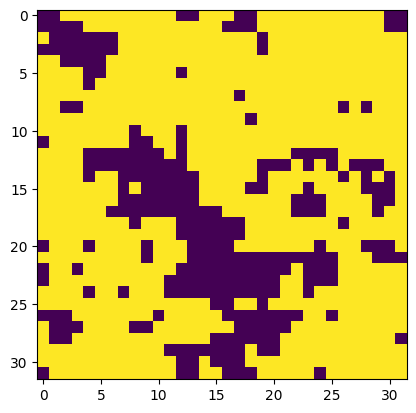

In [14]:
plt.imshow(snapshot[5])

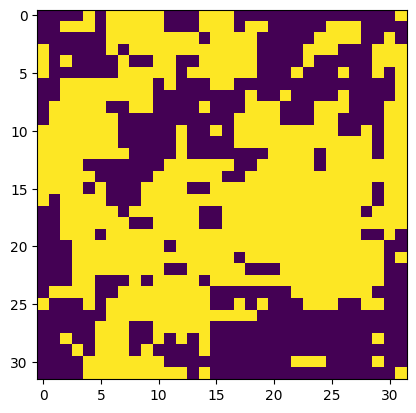

In [13]:
plt.imshow(snapshot[9])

<img src="M.png" width=500 height=500>
<img src="cv.png" width=500 height=500>
The results plotted above were obtained with sampsize 10M. For the the exercise there is no need to run such a long simulaiton. With sampsize 800k  a not too bad implementation should take ~3 minutes for each temperature.